# Cross Validation Notebook
Cross Validation or Out of Folds (OOF) scores notebook is used to tweak the various thresholds and test the Test-Time Augmentations (TTA)
Designed for multi model/fold ensemble evaluations.

Find the deployed version of the notebook on Colab: https://colab.research.google.com/drive/1Qvwr1MyDN96sUNl5DTUcTuW8xsAmMzXy?usp=sharing  
YoloV5 by default uses TensorBoard, some of my logs can be found on here: https://tensorboard.dev/experiment/0UjGUJATQ5CpbNuaBGOv8w/#scalars

## 1. Setup

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!pip install --upgrade --force-reinstall --no-deps albumentations

In [ ]:
import os
os.environ['KAGGLE_USERNAME']="NAME"
os.environ['KAGGLE_KEY']="KEY"

In [ ]:
# #Necessary imports
!kaggle datasets download -d shonenkov/weightedboxesfusion
!unzip weightedboxesfusion.zip -d weightedboxesfusion

!kaggle datasets download -d nvnnghia/yolov5train
!unzip yolov5train -d yolov5tta

!kaggle competitions download -c global-wheat-detection
!unzip global-wheat-detection.zip -d global-wheat-detection

In [ ]:
# Load models to test, my best public YoloV5 weights attached below

!kaggle datasets download -d ii5m0k3ii/mixup50e
!unzip mixup50e.zip -d weights
!rm -rf mixup50e.zip

In [ ]:
import sys
sys.path.insert(0, "./weightedboxesfusion")

import os
from ensemble_boxes import *
import torch
import random
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
import statistics as st
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## 2. Pre-processing and Data Loader Pipeline

In [ ]:
marking = pd.read_csv('./global-wheat-detection/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=1024, width=1024, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [ ]:
TRAIN_ROOT_PATH = './global-wheat-detection/train'

def collate_fn(batch):
    return tuple(zip(*batch))

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        image, boxes = self.load_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
#                     target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

In [ ]:
sys.path.insert(0, "./yolov5tta")
import argparse

from utils.datasets import *
from utils.utils import *

In [ ]:
source = './global-wheat-detection/train/'
weights = './weights/last_yolov5x_4M50fold0.pt'
imgsz = 1024
conf_thres = 0.1
iou_thres = 0.8

imagenames =  os.listdir(source)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load model
model = torch.load(weights, map_location=device)['model'].float()  # load to FP32
model.to(device).eval()
print('brrrr')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:657: SourceChangeWarning: source code of class 'models.yolo.Model' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


brrrr


## 3. Test-Time Augmentations
Contains general TTA such as Flips, Rotate and default YoloV5 Scale TTA. Also contains self implemented Brightness TTA.

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

from ensemble_boxes import *
def run_wbf(boxes, scores, image_size=1024, iou_thr=0.6, skip_box_thr=0.5, weights=None):
    labels = [np.zeros(score.shape[0]) for score in scores]
    boxes = [box/(image_size) for box in boxes]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size)
    return boxes, scores, labels

def TTAImage(image, index):
    #image=image.cpu().data.numpy()
    image1 = image
    if index==0: 
        rotated_image = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image
    elif index==1:
        rotated_image2 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        rotated_image2 = cv2.rotate(rotated_image2, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image2
    elif index==2:
        rotated_image3 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        rotated_image3 = cv2.rotate(rotated_image3, cv2.ROTATE_90_CLOCKWISE)
        rotated_image3 = cv2.rotate(rotated_image3, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image3
    elif index == 3:
        return image1
    
def rotBoxes90(boxes, im_w, im_h):
    ret_boxes =[]
    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = x1-im_w//2, im_h//2 - y1, x2-im_w//2, im_h//2 - y2
        x1, y1, x2, y2 = y1, -x1, y2, -x2
        x1, y1, x2, y2 = int(x1+im_w//2), int(im_h//2 - y1), int(x2+im_w//2), int(im_h//2 - y2)
        x1a, y1a, x2a, y2a = min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)
        ret_boxes.append([x1a, y1a, x2a, y2a])
    return np.array(ret_boxes)

def change_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v,value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def detect1Image(im0, imgsz, model, device, conf_thres, iou_thres, aug=False):
    #im0=im0.cpu().data.numpy()
    #im0=im0.transpose(1,2,0)

    img = letterbox(im0, new_shape=imgsz)[0]

    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)


    img = torch.from_numpy(img).to(device)
    img =  img.float()  # uint8 to fp16/32
    # img /= 255.0   
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    # Inference
    pred = model(img, augment=aug)[0]
    # print(pred.size())
    # Apply NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres)

    boxes = []
    scores = []
    for i, det in enumerate(pred):  # detections per image
        # save_path = 'draw/' + image_id + '.jpg'
        if det is not None and len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

            # Write results
            for *xyxy, conf, cls in det:
                boxes.append([int(xyxy[0]), int(xyxy[1]), int(xyxy[2]), int(xyxy[3])])
                scores.append(conf)

    return np.array(boxes), np.array(scores)

## 4. Making Predictions and Evaluation

In [ ]:
%%time

is_TTA= True
all_predictions = []

for fold_number in [0]:
    validation_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )

    validation_loader = DataLoader(
        validation_dataset,
        batch_size=2,
        shuffle=False,
        num_workers=2,
        drop_last=False,
        collate_fn=collate_fn
    )

    for images, targets, image_ids in tqdm(validation_loader, total=len(validation_loader)):
        images = torch.stack(images)
        images = images.cuda().float()
        for i in range(len(image_ids)):
            #boxes, scores = detect1Image(images[i,:,:,:], imgsz, model, device, conf_thres, iou_thres) #gives xyxy format output
            im01=images[i,:,:,:]
            im01=im01.cpu().data.numpy()
            im01=im01.transpose(1,2,0)
            im_w, im_h = im01.shape[:2]
            #s=[0.7,1.6]     #scaling factors

            if is_TTA:
                enboxes = []
                enscores = []
                #Rotation TTA
                for j in range(4):
                    im0 = TTAImage(im01, j)
                    boxes, scores = detect1Image(im0, imgsz, model, device, conf_thres, iou_thres, aug=True)
                    for _ in range(3-j):
                        boxes = rotBoxes90(boxes, im_w, im_h)
                        
                    enboxes.append(boxes)
                    enscores.append(scores) 
                
                #Scaling TTA
                """im0=(im01/s[0]).clip(max=255).astype('uint8')
                boxes, scores = detect1Image(im0, imgsz, model, device, conf_thres, iou_thres)
                enboxes.append(boxes)
                enscores.append(scores)

                im0=(im01/s[1]).astype('uint8')
                boxes, scores = detect1Image(im0, imgsz, model, device, conf_thres, iou_thres)
                enboxes.append(boxes)
                enscores.append(scores)

                #Brightness++
                im0 = change_brightness(im01, value=40)
                boxes, scores = detect1Image(im0, imgsz, model, device, conf_thres, iou_thres)
                enboxes.append(boxes)
                enscores.append(scores)
                
                #Brightness--
                im0 = change_brightness(im01, value=-40)
                boxes, scores = detect1Image(im0, imgsz, model, device, conf_thres, iou_thres)
                enboxes.append(boxes)
                enscores.append(scores)"""
                
                boxes, scores, labels = run_wbf(enboxes, enscores, image_size = im_w, iou_thr=0.6, skip_box_thr=0.5)
                #boxes = boxes.astype(np.int32).clip(min=0, max=im_w)
                
            else:
                enboxes = []
                enscores = []
                boxes, scores = detect1Image(im01, imgsz, model, device, conf_thres, iou_thres)
                enboxes.append(boxes)
                enscores.append(scores)

                boxes, scores, labels = run_wbf(enboxes, enscores, image_size = im_w, iou_thr=0.6, skip_box_thr=0.5)

            all_predictions.append({
                'pred_boxes': (boxes).clip(min=0, max=1023).astype(int),
                'scores': scores,
                'gt_boxes': (targets[i]['boxes'].cpu().numpy()).clip(min=0, max=1023).astype(int),
                'image_id': image_ids[i],
            })    

100%|██████████| 169/169 [05:38<00:00,  2.00s/it]

CPU times: user 4min 13s, sys: 1min 20s, total: 5min 34s
Wall time: 5min 38s


In [ ]:
#Scoring Metrics
import pandas as pd
import numpy as np
import numba
import re
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple


@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{TRAIN_ROOT_PATH}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[2], pred_box[3]),
            (220, 0, 0), 2
        )

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[2], gt_box[3]),
            (0, 0, 220), 2
        )

    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title(f"RED: Predicted & BLUE - Ground-truth \nShape: {sample.shape[:2]}" )

# Numba typed list!
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

In [ ]:
def calculate_final_score(all_predictions, score_threshold):
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]['gt_boxes'].copy()
        pred_boxes = all_predictions[i]['pred_boxes'].copy()
        scores = all_predictions[i]['scores'].copy()
        image_id = all_predictions[i]['image_id']

        indexes = np.where(scores>score_threshold)
        pred_boxes = pred_boxes[indexes]
        scores = scores[indexes]

        image_precision = calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form='pascal_voc')
        final_scores.append(image_precision)

    return np.mean(final_scores)

In [ ]:
%%time

best_final_score, best_score_threshold = 0, 0
for score_threshold in tqdm(np.arange(0, 1, 0.01), total=np.arange(0, 1, 0.01).shape[0]):
    final_score = calculate_final_score(all_predictions, score_threshold)
    if final_score > best_final_score:
        best_final_score = final_score
        best_score_threshold = score_threshold

100%|██████████| 100/100 [00:07<00:00, 12.84it/s]

CPU times: user 7.78 s, sys: 39.6 ms, total: 7.82 s
Wall time: 7.79 s


In [ ]:
print('-'*30)
print(f'[Best Score Threshold]: {best_score_threshold}')
print(f'[OOF Score]: {best_final_score:.4f}')
print('-'*30)

------------------------------
[Best Score Threshold]: 0.35000000000000003
[OOF Score]: 0.6590
------------------------------


## 5. Visualising predictions
Used to get some insights on the predictions.  
Can also be used to decide the thresholds in case of Re-Labeling is done for Noisy labels.

image 2: 0126b7d11   source: arvalis_1 
pred boxes: 26   gt boxes: 28
conf_thr: 0.35000000000000003
Precision: 0.4292586986184547


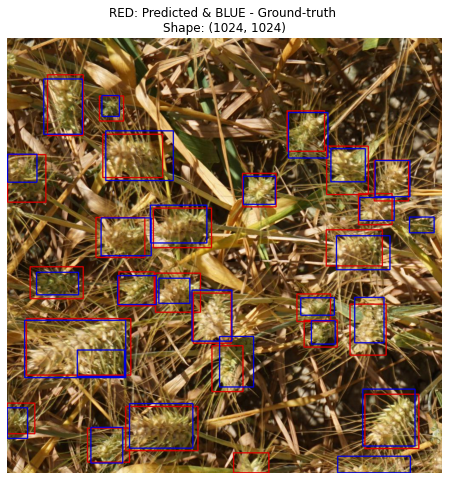

In [ ]:
count=0
pcn=[]
#best_score_threshold=0.0
for i in range(len(all_predictions)):
    gt_boxes = all_predictions[i]['gt_boxes'].copy()
    pred_boxes = all_predictions[i]['pred_boxes'].copy()
    scores = all_predictions[i]['scores'].copy()
    image_id = all_predictions[i]['image_id']

    indexes = np.where(scores>best_score_threshold)
    pred_boxes = pred_boxes[indexes]
    scores = scores[indexes]

    new=marking[marking['image_id']==image_id]['source']
    src=list(set(new))[0]

    img_precision = calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form='pascal_voc')
    pcn.append(img_precision)
    
    if i==2:
        #count+=1
        print(f'image {i}: {image_id}   source: {src} \npred boxes: {len(pred_boxes)}   gt boxes: {len(gt_boxes)}')
        print(f'conf_thr: {best_score_threshold}\nPrecision: {img_precision}')
        show_result(image_id, pred_boxes, gt_boxes)

#print(count)

mean: 0.6590
median: 0.6605


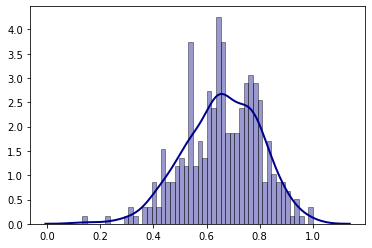

In [ ]:
print("mean: {:.4f}".format(st.mean(pcn)))
print("median: {:.4f}".format(st.median(pcn)))
sns.distplot(pcn, hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})